In [1]:
import pandas as pd
import os
import yaml
import torch
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
matplotlib.pyplot.rcParams['figure.figsize'] = (15, 6)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'

In [2]:
def compute_sparsity(model_fn, threshold=10e-3):
    is_zero = 0
    non_zero = 0
    for name, tensor in torch.load(model_fn).items():
        m = tensor.cpu().numpy()
        close = len(np.where(np.abs(m) <= threshold)[0])
        is_zero += close
        non_zero += (m.size - close)
    return is_zero, non_zero, is_zero / (is_zero + non_zero)
    
    
def get_min_loss(row):
    min_idx, min_dev_loss = min(enumerate(row['dev_loss']), key=lambda x: x[1])
    min_train_loss = row['train_loss'][min_idx]
    row['min_dev_loss'] = min_dev_loss
    row['min_train_loss'] = min_train_loss
    return row
    
    
def extract_language_name(field):
    fn = field.split('/')[-1]
    if 'dev' in fn:
        return '-'.join(fn.split('-')[:-1])
    return '-'.join(fn.split('-')[:-2])
    

def load_res_dir(basedir, include_sparsity=False):
    experiments = []
    for subdir in os.scandir(basedir):
        exp_d = {}
        with open(os.path.join(subdir.path, "config.yaml")) as f:
            exp_d.update(yaml.load(f))
        res_fn = os.path.join(subdir.path, "result.yaml")
        if os.path.exists(res_fn):
            with open(os.path.join(subdir.path, "result.yaml")) as f:
                exp_d.update(yaml.load(f))
        else:
            continue
        train_acc_path = os.path.join(subdir.path, "train.word_accuracy")
        if os.path.exists(train_acc_path):
            with open(train_acc_path) as f:
                exp_d['train_acc'] = float(f.read())
        else:
            print("Train accuracy file does not exist in dir: {}".format(subdir.path))
        dev_acc_path = os.path.join(subdir.path, "dev.word_accuracy")
        if os.path.exists(dev_acc_path):
            with open(dev_acc_path) as f:
                exp_d['dev_acc'] = float(f.read())
        else:
            print("Dev accuracy file does not exist in dir: {}".format(subdir.path))
        if include_sparsity:
            exp_d['sparsity'] = compute_sparsity(os.path.join(subdir.path, "model"), 10e-4)
        experiments.append(exp_d)
    experiments = pd.DataFrame(experiments)
    if include_sparsity:
        experiments['sparsity_ratio'] = experiments['sparsity'].apply(lambda x: x[2])
    experiments['language'] = experiments.dev_file.apply(extract_language_name)
    experiments = experiments.apply(get_min_loss, axis=1)
    experiments = experiments[experiments['dev_acc'].notnull()]
    experiments = experiments[experiments['dev_loss'].notnull()]
    experiments['train_size'] = experiments['train_file'].apply(lambda fn: fn.split('-')[-1])
    return experiments

In [3]:
%%time
luong = pd.concat([
    #load_res_dir("../exps/task1/luong/"),
    #load_res_dir("../exps/task1/reverse_luong/"),
    load_res_dir("../exps/task1/luong_new/"),
    #load_res_dir("../exps/task1/reverse_luong_new/"),
    #load_res_dir("../exps/task1/two_headed//"),
])

CPU times: user 12.6 s, sys: 140 ms, total: 12.7 s
Wall time: 15.8 s


In [4]:
luong.shape

(585, 45)

In [6]:
luong.groupby('language').size().sort_values(ascending=False)

language
zulu                   6
italian                6
georgian               6
german                 6
greek                  6
haida                  6
hebrew                 6
hindi                  6
hungarian              6
icelandic              6
irish                  6
kabardian              6
friulian               6
kannada                6
khaling                6
kurmanji               6
ladin                  6
latin                  6
latvian                6
lithuanian             6
livonian               6
yiddish                6
galician               6
french                 6
maltese                6
breton                 6
albanian               6
arabic                 6
armenian               6
asturian               6
                      ..
old-armenian           6
pashto                 6
old-saxon              6
norwegian-bokmaal      6
old-french             6
old-english            6
middle-low-german      6
old-church-slavonic    6
north-frisian   

In [144]:
luong[luong.language == 'russian'].dev_acc.sort_values()
luong.groupby('language').dev_acc.max().shape

(103,)

In [130]:
def extract_dataset_name(row):
    row['dataset'] = "{}:{}".format(row['language'], row['train_size'])
    return row

luong = luong.apply(extract_dataset_name, axis=1)

In [ ]:
luong["reverse"] = luong.train_file.str.contains("reverse")
luong["new"] = luong.experiment_dir.str.contains("_new")

luong.groupby(['reverse', 'new']).size()

# Is on-the-fly padding better than global padding

On-the-fly padding: pad every sample to the longest sample in the current batch

global padding: pad to the longest sample in the whole dataset


On-the-fly padding is much better if the target is not reversed. It is slightly better if the target is reversed.

In [ ]:
luong.groupby(['language', 'reverse', 'new']).max()['dev_acc'].unstack(['reverse', 'new']).describe()

In [ ]:
df = luong[(luong.reverse==False) & (luong.new==True)]
df.groupby('language').dev_acc.max().sort_values(ascending=False).tail(20)
high = df[df.train_size=='high']

high.groupby('language').dev_acc.max().sort_values(ascending=False).tail(20)

In [ ]:
high[high['language'] == 'norwegian-nynorsk'].experiment_dir.str[-20:]

# Random parameter search

In [7]:
luong_dir = "../exps/task1/luong_param_search/"
two_headed_dir = "../exps/task1/two_headed_param_search/"

hp_search = pd.concat([
    load_res_dir(luong_dir),
    #load_res_dir(two_headed_dir),
])

hp_search.shape

(100, 45)

In [9]:
hp_search.groupby('language').dev_acc.max()

language
breton    0.86
Name: dev_acc, dtype: float64

In [161]:
hp_search.groupby(['inflected_embedding_size', 'language'])[['dev_acc', 'train_acc']].agg(['mean', 'max', 'count'])

dev_acc              train_acc  \
                                         mean    max count      mean   
inflected_embedding_size language                                      
10                       breton      0.343175  0.870    63  0.406247   
20                       breton      0.484143  0.930   140  0.560406   
                         latin       0.601167  0.750     6  0.848050   
                         lithuanian  0.796381  0.869    21  0.924581   
30                       breton      0.504818  0.890   137  0.581582   
                         latin       0.605667  0.727     6  0.863533   
                         lithuanian  0.679667  0.847     9  0.790689   
50                       breton      0.605286  0.880    70  0.687162   
                         latin       0.687833  0.711     6  0.912533   
                         lithuanian  0.705692  0.851    13  0.870600   

                                                     
                                          max count  
inflected_embedding_size language                    
10                       breton      0.929904    63  
20                       breton      0.991931   140  
                         latin       0.957400     6  
                         lithuanian  0.970800    21  
30                       breton      0.981341   137  
                         latin       0.966100     6  
                         lithuanian  0.956800     9  
50                       breton      0.992436    70  
                         latin       0.970900     6  
                         lithuanian  0.958000    13

In [113]:
hp_search['overfit'] = (hp_search['train_acc'] - hp_search['dev_acc']) / hp_search['dev_acc']

In [147]:
hp_search.groupby(['model', 'language'])[['dev_acc', 'dev_loss', 'train_acc', 'train_loss']].agg(['mean', 'min', 'max', 'std'])

dev_acc                         train_acc  \
                                      mean    min    max       std      mean   
model                 language                                                 
LuongAttentionSeq2seq breton      0.213700  0.000  0.860  0.297541  0.255613   
ReinflectionSeq2seq   breton      0.490073  0.000  0.930  0.352023  0.565435   
                      latin       0.622625  0.188  0.727  0.145277  0.866425   
                      lithuanian  0.762317  0.485  0.869  0.095444  0.900432   

                                                              
                                     min       max       std  
model                 language                                
LuongAttentionSeq2seq breton      0.0000  0.933434  0.333626  
ReinflectionSeq2seq   breton      0.0000  0.992436  0.386032  
                      latin       0.6174  0.970900  0.092843  
                      lithuanian  0.6673  0.970800  0.073492

In [148]:
hp_search.groupby(['model', 'language']).running_time.describe()

count        mean         std         min  \
model                 language                                                
LuongAttentionSeq2seq breton      100.0   23.311421   22.495557    6.175356   
ReinflectionSeq2seq   breton      410.0   49.237659   42.533678    9.217657   
                      latin        16.0  610.322062  310.268698  272.218319   
                      lithuanian   41.0  969.904846  682.162438  310.291801   

                                         25%         50%          75%  \
model                 language                                          
LuongAttentionSeq2seq breton       10.099469   14.726238    26.593629   
ReinflectionSeq2seq   breton       24.188820   36.793076    57.320554   
                      latin       343.404546  570.258679   741.364062   
                      lithuanian  559.176595  829.122430  1165.072379   

                                          max  
model                 language                 
LuongAttentionSeq2seq breton       132.853282  
ReinflectionSeq2seq   breton       322.711144  
                      latin       1462.160368  
                      lithuanian  3921.219545

In [149]:
hp_search.groupby(['share_vocab', 'model'])[['dev_acc', 'train_acc']].agg(['mean', 'max', 'std', 'count'])

dev_acc                       train_acc  \
                                       mean   max       std count      mean   
share_vocab model                                                             
False       LuongAttentionSeq2seq  0.264815  0.86  0.313843    54  0.315525   
            ReinflectionSeq2seq    0.525580  0.89  0.338294   243  0.614994   
True        LuongAttentionSeq2seq  0.153696  0.82  0.268223    46  0.185281   
            ReinflectionSeq2seq    0.510853  0.93  0.345283   224  0.594489   

                                                             
                                        max       std count  
share_vocab model                                            
False       LuongAttentionSeq2seq  0.933434  0.349172    54  
            ReinflectionSeq2seq    0.988401  0.376117   243  
True        LuongAttentionSeq2seq  0.911246  0.303174    46  
            ReinflectionSeq2seq    0.992436  0.380732   224

In [150]:
hp_search.groupby(['early_stopping_ratio', 'model'])[['dev_acc', 'train_acc']].agg(['mean', 'max', 'std', 'count'])

dev_acc                        \
                                                mean   max       std count   
early_stopping_ratio model                                                   
0.8                  LuongAttentionSeq2seq  0.108000  0.73  0.215503    25   
                     ReinflectionSeq2seq    0.216957  0.84  0.260092    69   
1.0                  LuongAttentionSeq2seq  0.073704  0.53  0.147912    27   
                     ReinflectionSeq2seq    0.169355  0.84  0.258126    62   
1.2                  LuongAttentionSeq2seq  0.102400  0.75  0.207932    25   
                     ReinflectionSeq2seq    0.285125  0.87  0.299430    80   
1.5                  LuongAttentionSeq2seq  0.613913  0.86  0.237539    23   
                     ReinflectionSeq2seq    0.675393  0.87  0.189317    89   
1.7                  ReinflectionSeq2seq    0.805634  0.89  0.088467    41   
1.8                  ReinflectionSeq2seq    0.783364  0.88  0.111697    33   
2.0                  ReinflectionSeq2seq    0.805286  0.93  0.089701    56   
3.0                  ReinflectionSeq2seq    0.804838  0.89  0.121981    37   

                                           train_acc                            
                                                mean       max       std count  
early_stopping_ratio model                                                      
0.8                  LuongAttentionSeq2seq  0.123389  0.796268  0.230351    25  
                     ReinflectionSeq2seq    0.261827  0.924357  0.294891    69  
1.0                  LuongAttentionSeq2seq  0.101772  0.664650  0.178030    27  
                     ReinflectionSeq2seq    0.199779  0.920323  0.286631    62  
1.2                  LuongAttentionSeq2seq  0.128714  0.862330  0.243861    25  
                     ReinflectionSeq2seq    0.347434  0.973777  0.338275    80  
1.5                  LuongAttentionSeq2seq  0.717863  0.933434  0.223746    23  
                     ReinflectionSeq2seq    0.792245  0.976299  0.171574    89  
1.7                  ReinflectionSeq2seq    0.912596  0.974786  0.059512    41  
1.8                  ReinflectionSeq2seq    0.906543  0.981341  0.065408    33  
2.0                  ReinflectionSeq2seq    0.922558  0.991931  0.057027    56  
3.0                  ReinflectionSeq2seq    0.942068  0.992436  0.060273    37

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f6765eba8>]],
      dtype=object)

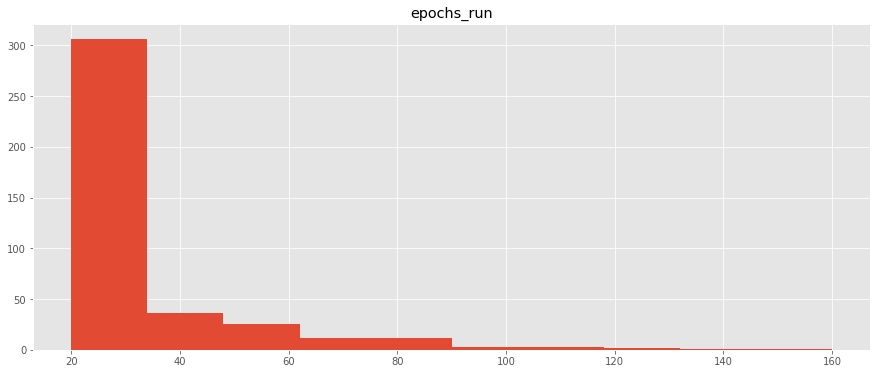

In [120]:
hp_search['epochs_run'] = hp_search.train_loss.apply(len)
hp_search.hist('epochs_run')

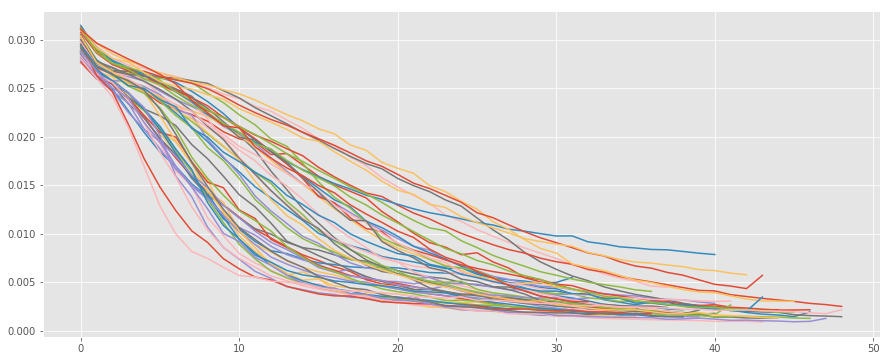

In [127]:
def plot_losses(row):
    train_loss = row['train_loss']
    dev_loss = row['dev_loss']
    plt.plot(dev_loss)
    
plot_losses(hp_search.iloc[0])
for row in hp_search[(hp_search.train_loss.apply(len) > 30) & (hp_search.train_loss.apply(len) < 50)].iterrows():
    plot_losses(row[1])